# Building confidence on explainability methods

Local explainability methods are recent, they keep being improved and research is very active in the field. Thus, one needs to be careful when interpreting those methods' outputs. 

Depending on the tasks and data, explainability methods may give different results. The purpose of the metrics presented below is to assess the degree of confidence in these cases. We will answer the following questions: 

- Do different explainability methods give similar explanations on average ? (**Consistency**)

- Is the explanation similar for similar instances ? (**Local stability**)

- Do a few features drive the model ? (**Approximation**)

<b>This short tutorial </b>presents an example of how those 3 metrics could be used on a classification case.

We used Kaggle's [Titanic](https://www.kaggle.com/c/titanic/data) dataset

In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

## Building Supervized Model

Let's start by loading a dataset and building a model that we will try to explain right after.


Load Titanic data

In [2]:
from shapash.data.data_loader import data_loading
titanic_df, titanic_dict = data_loading('titanic')
del titanic_df['Name']
y_df=titanic_df['Survived'].to_frame()
X_df=titanic_df[titanic_df.columns.difference(['Survived'])]

In [3]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,Third class,male,22.0,1,0,7.25,Southampton,Mr
2,1,First class,female,38.0,1,0,71.28,Cherbourg,Mrs
3,1,Third class,female,26.0,0,0,7.92,Southampton,Miss
4,1,First class,female,35.0,1,0,53.10,Southampton,Mrs
5,0,Third class,male,35.0,0,0,8.05,Southampton,Mr


Encode Titanic data

In [4]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

Train / Test Split + model fitting

In [5]:
n=200

Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=7)

# Subsample
Xtrain = Xtrain[:n].reset_index(drop=True)
ytrain = ytrain[:n].reset_index(drop=True)

In [6]:
clf = ExtraTreesClassifier(n_estimators=200).fit(Xtrain, ytrain.iloc[:,0])

## Select an explainability method

Now that the model is ready, we need to pick an explainability method. As mentioned earlier, many of them exist, with different theoretical foundation, underlying assumptions, and levels of maturity. Thus, results might differ significantly among methods. Can we trust them?

The **Consistency metric** compares methods between them and evaluates how close the explanations are from each other: if underlying assumptions lead to similar results, we would be more confident in using those methods. If not, careful consideration should be taken in the interpretation of the explanations

#### Use pre-computed contributions

First calculate contributions beforehand and use those ones in the metric using the _contributions_ argument.

The provided contributions must be given in a dictionary format, where the key is the method name, and the value is a pandas DataFrame with the contributions.

Let's for example calculate contributions separately:

#### Then, we need to instantiate and compile the Consistency object

In [7]:
from shapash.explainer.consistency import Consistency
import shap

In [8]:
import logging
logging.getLogger("shap").setLevel(logging.WARNING)

treeSHAP = shap.TreeExplainer(clf).shap_values(Xtrain[:n], check_additivity=False)[:,:,1]
samplingSHAP = shap.SamplingExplainer(clf.predict_proba, shap.kmeans(Xtrain, 10)).shap_values(Xtrain[:n], check_additivity=False)[:,:,1]
kernelSHAP = shap.KernelExplainer(clf.predict_proba, shap.kmeans(Xtrain, 10)).shap_values(Xtrain[:n], check_additivity=False)[:,:,1]

treeSHAP = pd.DataFrame(treeSHAP, columns=Xtrain[:n].columns)
samplingSHAP = pd.DataFrame(samplingSHAP, columns=Xtrain[:n].columns)
kernelSHAP = pd.DataFrame(kernelSHAP, columns=Xtrain[:n].columns)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# The format must be a dictionary where keys are methods names and values are pandas DataFrames: be careful to have dataframes with same shape, index and column names
contributions = {"tree\nSHAP": treeSHAP, "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}

index = [45, 36, 12, 17, 29]
cns = Consistency()
cns.compile(contributions=contributions,
            x=Xtrain[:n] #Optionnal, needed to display pairwise_consistency_plot
            )

#### We can now display the consistency plot:

Two parameters can be chosen in those graphs:
* _selection:_ a sample of the dataset on which to evaluate the metric expressed as a list of indices (by default take the whole dataset if not too big)

* *max_features*: the number of features displayed in the graph (the most significant ones are selected)

For each pair of explainability methods, the metric compares the explanations across the dataset (or a sample if specified) and calculates an average distance between the explainability methods. Two plots are proposed:

* the first graph shows the aforementioned distances between methods on a 2D plan.
    * As we can see here, "shap" and "acv" are more similar than "lime".

* the second graph serves as a support for the first one: it gives a better sense of what the distances mean (what is 0.73? is it acceptable or not?). To do so, the metric extracts 5 real comparisons from the dataset (examples are represented by their Id in the dataframe) with distances similar to those in the first plot.    

Depending on the selected methods, examples above show how different the contributions could be. Interpreting them must be done carefully.

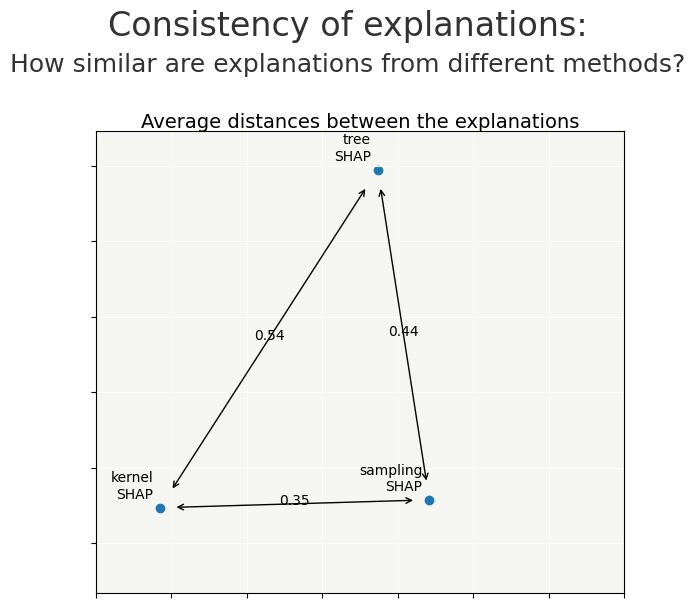

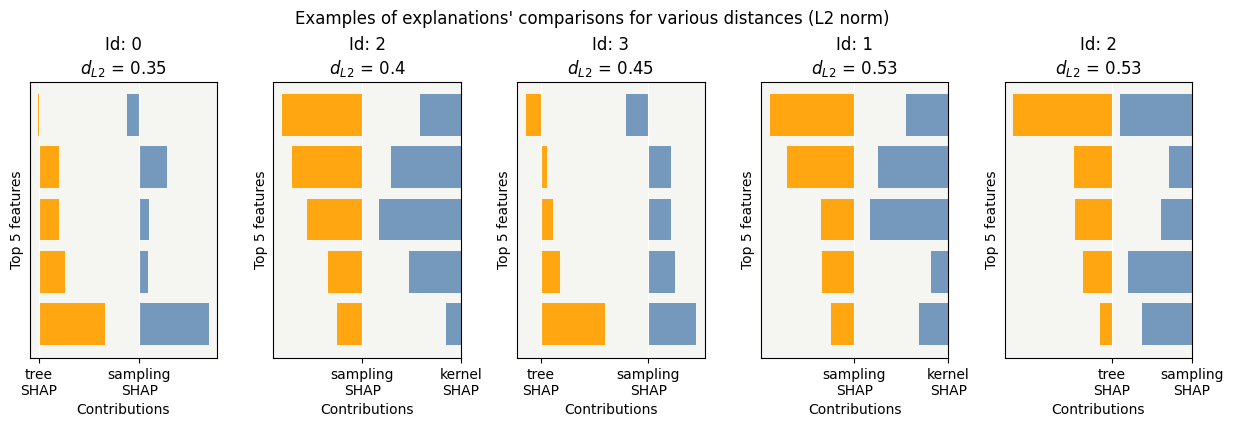

In [10]:
cns.consistency_plot(selection=index, max_features=5)

### Zooming on each feature : the pairwise consistency plot

The consistency plot illustrated above displays the *average* distances between multiple explainability methods across all the features. However, one might want to investigate those differences on a feature level. To do so, the plot below is proposed: 

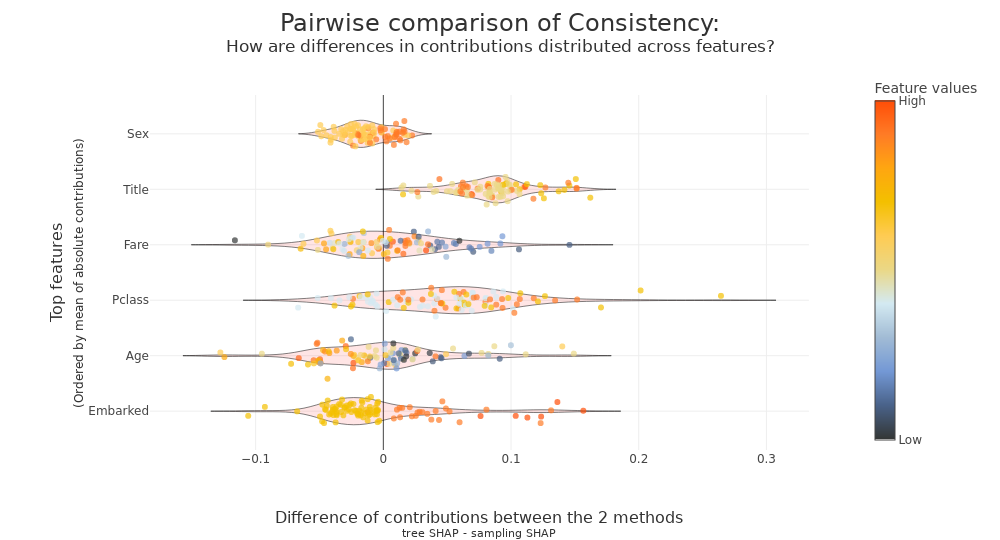

In [11]:
cns.pairwise_consistency_plot(methods=["tree\nSHAP", "sampling\nSHAP"], max_features=6)

The plot takes as input two explainability methods and outputs the difference of the contributions for each feature across the dataset (or a sample, by default). Only top features according to the mean of absolute constributions are displayed, ranked from the most important to the least.

The position on the x-axis shows how different the contributions are in each direction: points centered around 0 indicate little to no difference between the explainability methods, as opposed to points far away.

The colorbar represents the feature values. Based on that, it is possible to understand if differences between methods have a recurring pattern, helping to identify groups of datapoints with similar contributions. For example, looking at the the *Sex* feature, shap seems to constantly overestimate contributions for males with respect to lime; which is not necessarily the case for the *Pclass* feature.

## Evaluate the compacity of the explanations

What if the model uses tens or hundreds of features? Is it still going to be easy to understand how it works? Probably not. Indeed, the number of features greatly affects explainability

The **Compacity metric** measures how well each decision can be explained by relying on relatively few features, which may however be different from one instance to another

The idea is the following: _for each instace, we select the features with the highest contributions and we look at how well they approximate the model. Results are then aggregated across the whole dataset (or a sample of it) and displayed_

#### First, we need to instantiate and compile a SmartExplainer

In [12]:
from shapash import SmartExplainer

In [13]:
response_dict = {0: 'Death', 1:' Survival'}

In [14]:
xpl = SmartExplainer(
    model=clf, 
    preprocessing=encoder, 
    features_dict=titanic_dict, # Optional parameters
    label_dict=response_dict    # Optional parameters, dicts specify labels 
) 

In [15]:
xpl.compile(x=Xtrain)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fdd6789b5b0>


#### We can now display the consistency plot:

In [ ]:
xpl.plot.compacity_plot()

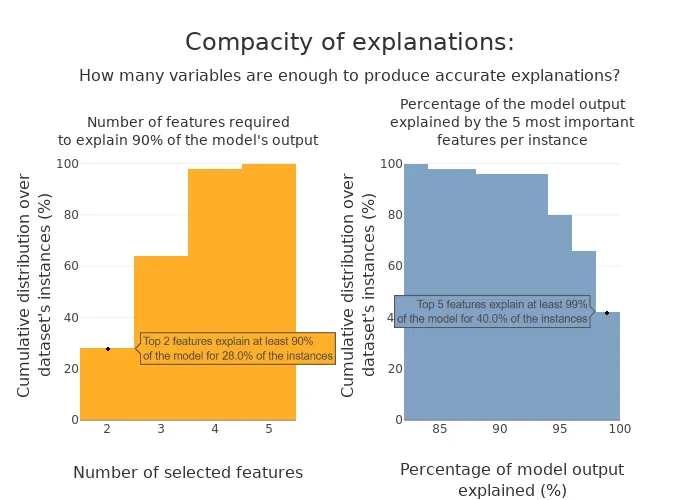

We want to measure how well the sum of the most important contributions approximates the global decision of the model. The two graphs show the link between the level of approximation, the number of required features to reach it and the proportion of the dataset on which it works.

* In the left graph, for example, we can read that top 4 features reach the default approximation for 94% of the instances. Thus, if we needed to provide accurate explanations about the model, a small subset of features will provide a reliable explanation for a vast majority of instances

* In the right graph, for example, we can read that top 5 features reach 89% of the reference model for 98% of the instances. Thus, if we needed something extremely precise, we would probably need to consider all features in the explanations

Multiple parameters can be modified, such as:

* *selection*: a sample of the dataset on which to evaluate the metric expressed as a list of indices (by default take the whole dataset if not too big)

* *approx*: how close we want to be the reference model with all features (default 90%) -- Left graph

* *nb_features*: how many features are selected to evaluate the approximation (default 5) -- Right graph

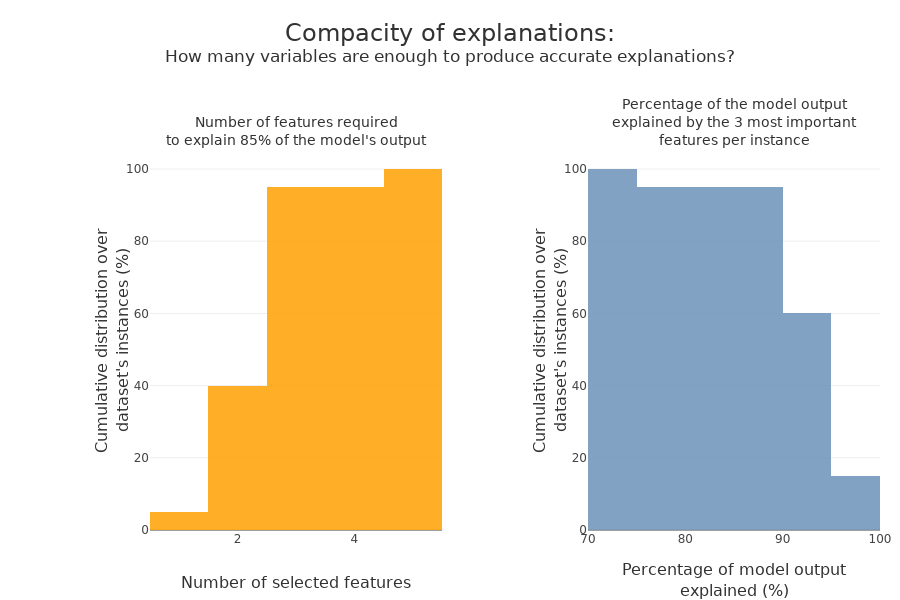

In [17]:
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

xpl.plot.compacity_plot(selection=index, approx=.85, nb_features=3)

## Evaluate the stability of the explanations

To increase confidence in the explanation, measuring their stability is important.

We define stability as follows: _if instances are very similar, then one would expect the explanations to be similar as well.
Therefore, locally stable explanations are an important factor that help build trust around a particular explanation._

The similarity between instances is evaluated under two criteria: (1) the instances must be close in the feature space and (2) have similar model outputs.

#### We can now display the stability plot:

In [18]:
xpl.plot.stability_plot()

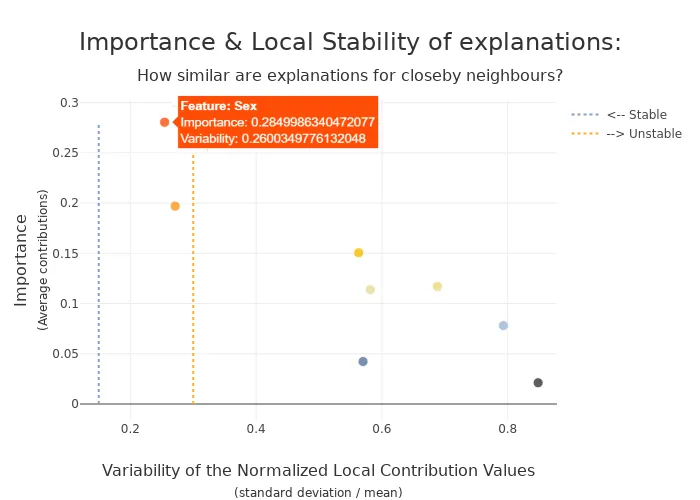

The above plot looks at the neighborhood around each provided instance (reminder: neighborhood in terms of features and model output) and shows:

* the average importance of the feature across the dataset based on its contributions (y-axis)

* the average variability of the feature across the instances' neighborhood (x-axis)

Left features are stable in the neighborhood, unlike those on the right. Top features are important, unlike bottom ones

* Here, features like "Sex", "Title" and "Class" in the left-hand side seem to have strong and relatively stable contributions, so one might be more confident in using them for explanations.
* On the other hand, features like "Fare" and "Port of embarcation" are much more unstable, and we might want to be careful before interpreting explanations around those features

Multiple parameters can be modified, such as:

* *selection*: a sample of the dataset on which to evaluate the metric expressed as a list of indices (by default take the whole dataset if not too big)

* *max_features*: the number of features displayed in the graph (the most significant ones are selected)

* *distribution*: changes the type of displayed graph

**Note:** Means are not always representative of the individual behaviors. Thus, we might look at the distribution of variability as well:

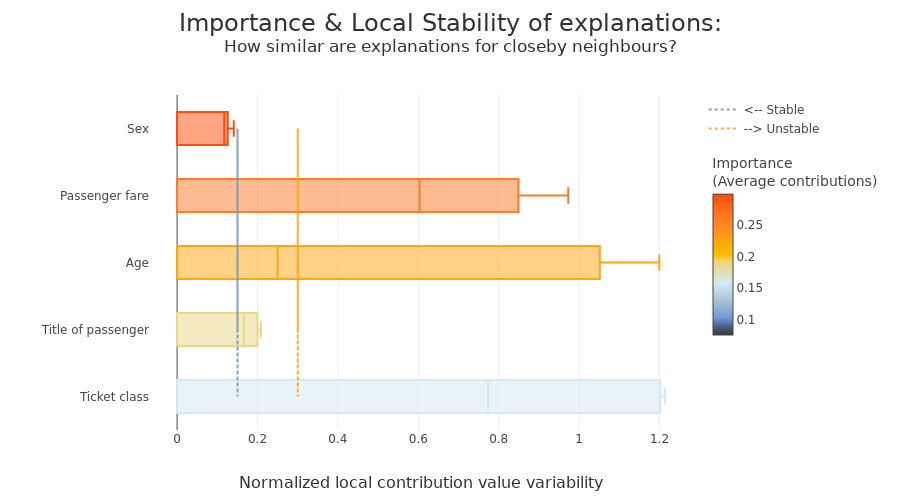

In [64]:
index = [45, 36, 12, 17, 29]

# Using distribution = "boxplot" or "violin" displays distributions of variability instead of means

xpl.plot.stability_plot(selection=index, max_features=5, distribution="boxplot")

Stability can also be evaluated for a single instance. In that case, contributions are directly compared against neighbors and displayed:

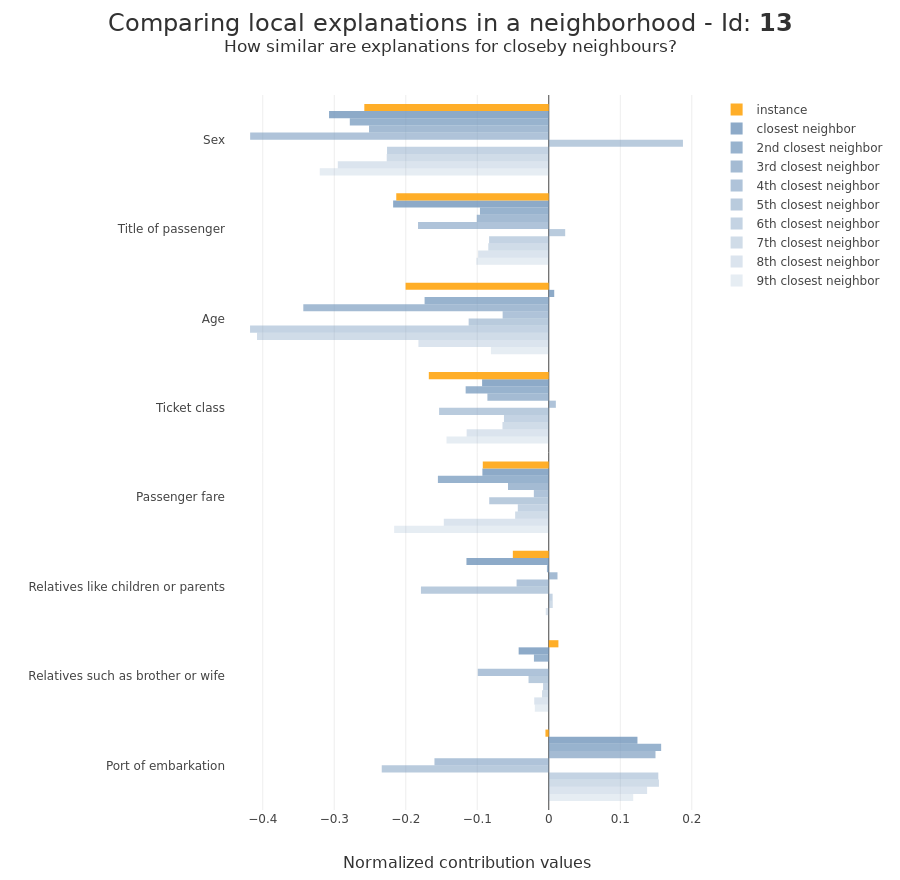

In [60]:
xpl.plot.local_neighbors_plot(index=13)

We can see here how difficult it is to interpret contributions sometimes: the feature _Port of embarkation_ gives completely opposite suggestions in the same neighborhood.